In [1]:
!mkdir -p /tmp/pip/cache/
!cp ../input/segmentationmodelszip/pretrainedmodels-0.7.4.xyz /tmp/pip/cache/pretrainedmodels-0.7.4.tar.gz
!cp ../input/segmentationmodelszip/segmentation_models_pytorch-0.0.1-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/segmentationmodelszip/torchfile-0.1.0.xyz /tmp/pip/cache/torchfile-0.1.0.tar.gz
!cp ../input/segmentationmodelszip/torchnet-0.0.4.xyz /tmp/pip/cache/torchnet-0.0.4.tar.gz
!cp ../input/segmentationmodelszip/torchvision-0.2.2-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/segmentationmodelszip/tqdm-4.19.9-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/segmentationmodelszip/visdom-0.1.8.8.xyz/visdom-0.1.8.8.xyz /tmp/pip/cache/visdom-0.1.8.8.tar.gz

In [2]:
!ls /tmp/pip/cache

pretrainedmodels-0.7.4.tar.gz
segmentation_models_pytorch-0.0.1-py2.py3-none-any.whl
torchfile-0.1.0.tar.gz
torchnet-0.0.4.tar.gz
torchvision-0.2.2-py2.py3-none-any.whl
tqdm-4.19.9-py2.py3-none-any.whl
visdom-0.1.8.8.tar.gz


In [3]:
!pip install --no-index --find-links /tmp/pip/cache/ segmentation-models-pytorch

Looking in links: /tmp/pip/cache/
Processing /tmp/pip/cache/segmentation_models_pytorch-0.0.1-py2.py3-none-any.whl
Processing /tmp/pip/cache/pretrainedmodels-0.7.4.tar.gz
Processing /tmp/pip/cache/torchvision-0.2.2-py2.py3-none-any.whl
Processing /tmp/pip/cache/torchnet-0.0.4.tar.gz
Processing /tmp/pip/cache/visdom-0.1.8.8.tar.gz
Processing /tmp/pip/cache/tqdm-4.19.9-py2.py3-none-any.whl
Processing /tmp/pip/cache/torchfile-0.1.0.tar.gz
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=6d37917473c878063eada2e58679c3ad92e8c36e6f8967dd34d952b7800288b4
  Stored in directory: /root/.cache/pip/wheels/10/1f/03/61c3da39f4907ac6ad69ce8078e5be835c4681b842d110d52f
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29741 sha256=e05a3b2c0d40c8cb1d85246864c81104ef68ea118c8022d6820650593a188fb7
  Stored in directory: /root/.cache/pip/wheels/a5/f7/a7/a0cc5d0c9dd698d29d091f17e2360b0fc08fb2582e5ec605d9
  Created wheel for vi

In [4]:
import os
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib
import segmentation_models_pytorch as smp
import cv2
import pydicom as dicom
import torch
import ast # https://www.geeksforgeeks.org/python-convert-a-string-representation-of-list-into-list/
from skimage import exposure
import segmentation_models_pytorch as smp
from PIL import Image 
import glob

In [5]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp ../input/resnet34/resnet34-333f7ec4.pth /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
!cp ../input/resnet50/resnet50-19c8e357.pth /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
!cp ../input/resnet152/resnet152-b121ed2d.pth /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
!cp ../input/vgg19/vgg19-dcbb9e9d.pth /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth

# Preprocess DataFrames

In [6]:
train_image_df = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')
train_study_df = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')

In [7]:
try:
    train_study_df['id'] = train_study_df['id'].str.replace('_study',"")
    train_study_df.rename(columns={'id': 'StudyInstanceUID'}, inplace=True)
    
except KeyError:
    print(train_study_df.head())

In [8]:
train_image_df = train_image_df.merge(train_study_df, on='StudyInstanceUID')

In [9]:
class_names = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
classes = {0: 'negative', 1: 'typical', 2: 'indeterminate', 3: 'atypical'}
study_label = "study_label"

In [10]:
try:
    train_image_df.loc[train_image_df[class_names[0]] == 1, study_label] = 0
    train_image_df.loc[train_image_df[class_names[1]] == 1, study_label] = 1
    train_image_df.loc[train_image_df[class_names[2]] == 1, study_label] = 2
    train_image_df.loc[train_image_df[class_names[3]] == 1, study_label] = 3

    train_image_df.drop(class_names, axis=1, inplace=True)
    train_image_df.head(4)
    
except KeyError:
    print(train_image_df.head(4))

# Exaple of Image Data

In [11]:
from pydicom import dcmread
from pydicom.pixel_data_handlers.util import convert_color_space

In [12]:
def get_image(id):
    path_train = '/kaggle/input/siim-covid19-detection/' + 'train/' + train_image_df.loc[id, 'StudyInstanceUID']
    last_folder_in_path = os.listdir(path_train)[0]
    path_train = path_train + '/{}/'.format(last_folder_in_path)
    img_id = train_image_df.loc[id, 'id'].replace('_image','.dcm')
#     print(path_train + img_id)
    data_file = dicom.dcmread(path_train + img_id)
    img = data_file.pixel_array
    img_2d = img.astype(float)
    img_2d_scaled = (np.maximum(img_2d, 0) / img_2d.max() * 255.0)
    img_2d_scaled = np.uint8(img_2d_scaled)
    img = np.stack((img, ) * 3, axis=-1)
    
    return img_2d_scaled

In [13]:
train_image_label_df = train_image_df[["id", "study_label"]].copy()

In [14]:
def draw_image(id):
    figure, ax = plt.subplots(1)

    img = get_image(id)
    if (train_image_df.loc[id, 'boxes'] == train_image_df.loc[id, 'boxes']):
        boxes = ast.literal_eval(train_image_df.loc[id, 'boxes'])

        for box in boxes:
            print(boxes) 
            
            mask = cv2.rectangle(img, (int(box['x']), int(box['y'])), 
                                      (int(box['x'] + box['width']), int(box['y'] + box['height'])), 
                                      (0, 0, 255), -1)
            
            ax.imshow(img)
            ax.set_title(train_image_df.loc[id, 'study_label'].split(' ')[0])


In [15]:
def get_mask(id):
    img = get_image(id)
    y = len(img[0])
    x = len(img)
    img = np.zeros((x, y, 3), np.uint8)
    
    if (train_image_df.loc[id, 'boxes'] == train_image_df.loc[id, 'boxes']):
        boxes = ast.literal_eval(train_image_df.loc[id, 'boxes'])
        
        for box in boxes:      
            mask = cv2.rectangle(img, (int(box['x']), int(box['y'])), 
                                      (int(box['x'] + box['width']), int(box['y'] + box['height'])), 
                                      (0, 0, 255), -1)
    return img

In [16]:
train_image_label_df['id'] = train_image_label_df['id'].str.replace('_image', '.png')

In [21]:
train_img_dir = "./train_images"
train_mask_dir = "./train_masks"
validation_img_dir = "./validation_images"
validation_mask_dir = "./validation_masks"
test_img_dir = "./test_images"
test_mask_dir = "./test_masks"

# Train, Validation, Test Splits | for the Segmentation model

In [22]:
# remove previous folders
########## RM RF ##########
try:
    import shutil
    shutil.rmtree("train_images")
    shutil.rmtree("train_masks")
    shutil.rmtree("test_images")
    shutil.rmtree("test_masks")
    shutil.rmtree("validation_images")
    shutil.rmtree("validation_masks")
except:
    pass

# create folders to store data
!mkdir train_images
!mkdir train_masks

!mkdir test_images
!mkdir test_masks

!mkdir validation_images
!mkdir validation_masks

In [23]:
# define data volume
test_data = 0.1
validation_data = 0.2
skip = 6
samples = 1000 * skip

In [24]:
stop_train = int(samples * (1 - (test_data + validation_data)))

start_test = int(stop_train)
stop_test = int(samples * (1 - validation_data))

start_val = int(stop_test)
stop_val = int(samples)

In [25]:
remove_idxs_train = []
remove_idxs_test = []
remove_idxs_val = []
size = 64

def create_imgs():
    for i in range(0, stop_train):
        if i % skip == 0:
            try:
                name = train_image_label_df.loc[i, 'id']

                img = get_image(i)
                img = np.array(img)
                img = cv2.resize(img, (size, size))
                cv2.imwrite(f"./train_images/{name}", img)

                mask = get_mask(i)
                mask = np.array(mask)
                mask = cv2.resize(mask, (size, size))
                cv2.imwrite(f"./train_masks/{name}", mask)

            except (FileNotFoundError, RuntimeError) as e:
                remove_idxs_train.append(i)
                print(f"train file {name} not found at index {i}")
                pass
        else:
            remove_idxs_train.append(i)
        
    for j in range(start_test, stop_test):
        if j % skip == 0:
            try:
                name = train_image_label_df.loc[j, 'id']

                img = get_image(j)
                img = np.array(img)
                img = cv2.resize(img, (size, size))
                cv2.imwrite(f"./test_images/{name}", img)

                mask = get_mask(j)
                mask = np.array(mask)
                mask = cv2.resize(mask, (size, size))
                cv2.imwrite(f"./test_masks/{name}", mask)

            except (FileNotFoundError, RuntimeError) as e:
                remove_idxs_test.append(j)
                print(f"test file {name} not found at index {j}")
                pass
        else:
            remove_idxs_test.append(j)
        
    for k in range(start_val, stop_val):
        if k % skip == 0:
            try:
                name = train_image_label_df.loc[k, 'id']

                img = get_image(k)
                img = np.array(img)
                img = cv2.resize(img, (size, size))
                cv2.imwrite(f"./validation_images/{name}", img)

                mask = get_mask(k)
                mask = np.array(mask)
                mask = cv2.resize(mask, (size, size))
                cv2.imwrite(f"./validation_masks/{name}", mask)

            except (FileNotFoundError, RuntimeError) as e:
                remove_idxs_val.append(k)
                print(f"test file {name} not found at index {k}")
                pass
        else:
            remove_idxs_val.append(k)
        
create_imgs()

train file 05c063f5cef5.png not found at index 138
train file 04f41a8958f7.png not found at index 150
train file 11f46d9df786.png not found at index 180
train file 9a335ce0bca4.png not found at index 204
train file 1c0d8460a527.png not found at index 234
train file 19ef72ca62b8.png not found at index 252
train file 08acae0bf785.png not found at index 258
train file 0a0cbc610620.png not found at index 294
train file 0b020a7aff0a.png not found at index 318
train file c7925ab50eb0.png not found at index 354
train file 0e2691505e53.png not found at index 408
train file 2204baf77803.png not found at index 474
train file 12e97ed89297.png not found at index 540
train file 13ff01cf36f8.png not found at index 576
train file 16c9f1b33188.png not found at index 630
train file 1701be774ecb.png not found at index 636
train file e73f2cc047ad.png not found at index 642
train file 19fc87ff0612.png not found at index 708
train file 33c95dbfe335.png not found at index 714
train file 1b3dcbce0fa2.png not

In [26]:
print(len(os.listdir("./train_images")))
print(len(os.listdir("./test_images")))
print(len(os.listdir("./validation_masks")))

630
88
187


In [28]:
train_df = train_image_label_df
train_df = train_df.head(stop_train)
train_df = train_df.drop(remove_idxs_train) # TODO: fix deletion of features


test_df = train_image_label_df.iloc[start_test : stop_test]
test_df = test_df.drop(remove_idxs_test)

val_df = train_image_label_df.iloc[start_val : stop_val]
val_df = val_df.drop(remove_idxs_val)

# Custom Dataset

In [29]:
from torch.utils.data import DataLoader
from albumentations import Resize, Normalize, Compose
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset
import math
import albumentations as album

import torch
import torch.nn as nn

In [30]:
class SegmentationDataset(Dataset):
    def __init__(
            self, 
            annotations_file, 
            img_dir, 
            mask_dir,
            augmentation=None, 
    ):
        
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        self.augmentation = augmentation
    
        
    def __len__(self):
        try:
            return len(self.img_labels)
        except TypeError:
            return 1  
        
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        mask_path = os.path.join(self.mask_dir, self.img_labels.iloc[idx, 0])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)    
    
        image = np.asarray(image).astype('float32')
        mask = np.asarray(mask).astype('float32')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        image = np.stack((image, ) * 3, axis=0)
        image = (image / image.max() * 255).astype(np.float32)        
        
        mask = (mask / 255).astype(np.float32)
        if (mask.ndim == 3):
            mask = mask[:, :, 0]        

        mask = np.expand_dims(mask, axis=0)

            
        return image, mask

In [31]:
def get_training_augmentation():
    train_transform = [    
        Resize(64, 64),
        album.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
#         album.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=1),
#         album.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1),
#         album.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        album.OneOf(
            [
                album.HorizontalFlip(p=0.5),
#                 album.VerticalFlip(p=0.5),
#                 album.RandomRotate90(p=0.75),
#                 album.CenterCrop(64, 64),
                album.GaussianBlur(p=0.25),
                album.InvertImg(p=0.35)
            ],
            p=0.75,
        ),
#         ToTensorV2(),
    ]
    return album.Compose(train_transform)

In [32]:
def get_validation_augmentation():
    train_transform = [    
        Resize(64, 64),
#         album.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),
    ]
    return album.Compose(train_transform)

(3, 64, 64) (1, 64, 64)
1.5108076 255.0 (64, 64)
0.0 1.0 (64, 64)


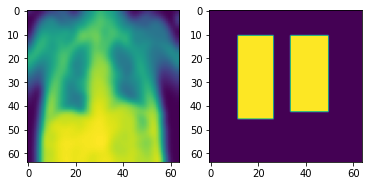

In [33]:
# FOR TESTING
train_img_dir = "./train_images"
train_mask_dir = "./train_masks"
fig, ax = plt.subplots(1, 2)

augmented_dataset = SegmentationDataset(
    train_df, train_img_dir, train_mask_dir,
    augmentation=get_training_augmentation(),
)
img, mask = augmented_dataset[0]

print(img.shape, mask.shape)

img = img[0, :, :]
mask = mask[0, :, :]

print(img.min(), img.max(), img.shape)
print(mask.min(), mask.max(), mask.shape)

ax[0].imshow(img);
ax[1].imshow(mask);

# Prepare data for the model

In [34]:
ENCODER = "resnet152"
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    activation=ACTIVATION,
    classes=1, 
)

preprocess_func = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [35]:
training = True
train_logs_list, valid_logs_list = [], []
best_iou_score = -math.inf

if not training:
    # use the pretrained model
    model_dir = '../input/modelv2/best_model_test (6).pth'
    model = torch.load(model_dir)

In [36]:
train_dataset = SegmentationDataset(
    train_df, train_img_dir, train_mask_dir,
    augmentation=get_training_augmentation(),
)

valid_dataset = SegmentationDataset(
    val_df, validation_img_dir, validation_mask_dir,
    augmentation=get_validation_augmentation(),
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [37]:
train_features, train_masks = next(iter(train_loader))

In [38]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Masks batch shape: {train_masks.size()}")

Feature batch shape: torch.Size([4, 3, 64, 64])
Masks batch shape: torch.Size([4, 1, 64, 64])


torch.Size([3, 64, 64])
torch.Size([64, 64])


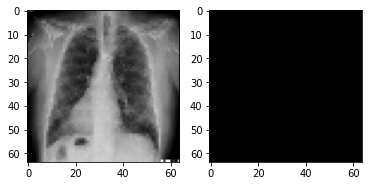

In [39]:
index = 0
fig, ax = plt.subplots(1, 2)

img = train_features[index].squeeze()
mask = train_masks[index].squeeze()

print(img.shape)
print(mask.shape)

img = img[0, :, :]
img = np.array(img)

ax[0].imshow(img, cmap="gray");
ax[1].imshow(mask, cmap="gray");

# Segmentation model

In [40]:
trainmodel = True
epochs = 65

# loss = smp.utils.losses.JaccardLoss()
loss = smp.utils.losses.DiceLoss()
# loss = nn.BCEWithLogitsLoss()
loss.__name__ = "DiceLoss"

metrics = [ 
    smp.utils.metrics.IoUMetric(threshold=0.5),
#     smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5,)

In [41]:
trainepoch = smp.utils.train.TrainEpoch(model, 
                                        loss=loss, 
                                        optimizer=optimizer, 
                                        metrics=metrics, 
                                        verbose=True)

validepoch = smp.utils.train.ValidEpoch(model, 
                                        loss=loss, 
                                        metrics=metrics, 
                                        verbose=True)

In [ ]:
%%time

for i in range(epochs):
    print(f'\nEpoch: {i}')
    trainlogs = trainepoch.run(train_loader)
    validlogs = validepoch.run(valid_loader)
    lr_scheduler.step()

    train_logs_list.append(trainlogs)
    valid_logs_list.append(validlogs)
    
    if best_iou_score < validlogs['iou']:
        best_iou_score = validlogs['iou']
        torch.save(model, './best_model_test.pth')
        print("New model saved")


Epoch: 0
train:   8%|▊         | 12/158 [00:19<03:38,  1.49s/it, DiceLoss - 0.7427, iou - 0.1684]

In [43]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

""


In [44]:
# Тут не дуже ясно чому iou score більше 1 та менше 0 може бути
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou.tolist(), "green", lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou.tolist(), "red", lw=3, label = 'Valid')

plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend(loc='best')
plt.grid()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'iou'

In [45]:
# plt.plot(train_logs_df.index.tolist(), train_logs_df.jaccard_loss.tolist(), "green", lw=3, label = 'Train')
# plt.plot(valid_logs_df.index.tolist(), valid_logs_df.jaccard_loss.tolist(), "red", lw=3, label = 'Valid')

plt.plot(train_logs_df.index.tolist(), train_logs_df.DiceLoss.tolist(), "green" , lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.DiceLoss.tolist(), "red" , lw=3, label = 'Valid')

plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'DiceLoss'

In [46]:
best_model = torch.load('./best_model_test.pth')

test_images_dir = "./test_images"
test_masks_dir = "./test_masks"

test_data = SegmentationDataset(
    test_df, test_images_dir, test_masks_dir,
    augmentation=get_validation_augmentation(),
)

val_data = SegmentationDataset(
    val_df, validation_img_dir, validation_mask_dir,
    augmentation=get_validation_augmentation(),
)

extra_test_data = SegmentationDataset(
    train_df, train_img_dir, train_mask_dir,
    augmentation=get_validation_augmentation(),
)

FileNotFoundError: [Errno 2] No such file or directory: './best_model_test.pth'

In [47]:
size = 64
threshold = 150
average_iou = []

def visualize_pred(images):
    names = ["Image", "True Mask", "Predicted Mask", "Diff"]
    plt.figure(figsize=(10, 5))
    n = len(images)
    
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.title(names[i])
        image = images[i]
        
        if image.shape[0] == 3:
            image = image[0, :, :]
        plt.imshow(image)
    plt.show()


for i in range(8):
    index = np.random.choice(len(test_data))
    
    image_vis, mask_vis = test_data[index]
    
    image_vis = np.array(image_vis).astype(np.float32)
    mask_vis = np.array(mask_vis).astype(np.float32)
    image_vis = image_vis[0, :, :]
    mask_vis = mask_vis[0, :, :]
    
    image_vis = cv2.resize(image_vis, (size, size))
    mask_vis = cv2.resize(mask_vis, (size, size))
    
    image_vis = np.stack((image_vis, ) * 3, axis=0)
    
    x_tensor = torch.from_numpy(image_vis).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
#     temp_mask = pr_mask.squeeze()
    temp_mask = pr_mask.squeeze(0).squeeze(0).detach().cpu().numpy() > 0.5
    pr_mask = pr_mask.squeeze().round()
#     pr_mask = pr_mask.squeeze().numpy() > 0.8
#     print(pr_mask)
    
#     diff_mask = (pr_mask - mask_vis)
#     pr_mask = (pr_mask.squeeze() > 0.8)
    pr_mask = np.array(pr_mask)
    mask_vis = np.array(mask_vis)
    diff_mask = cv2.bitwise_and(pr_mask, mask_vis)
    
    # For the score
    _intersection = cv2.bitwise_and(pr_mask, mask_vis)
    _union = cv2.bitwise_or(pr_mask, mask_vis)
    
#     pr_mask = (pr_mask.squeeze().numpy() > 0.8)
#     temp_mask = pr_mask.squeeze()
    pr_mask *= 255
    pr_mask = pr_mask.astype(np.uint8)
#     pr_mask = cv2.cvtColor(pr_mask,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(pr_mask, threshold, 255, cv2.THRESH_BINARY)[1]
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        cv2.rectangle(
            pr_mask, 
            (x, y), 
            (x + w, y + h), 
            (255, 0, 0), 
            -1)

    i_score = sum(sum(_intersection))
    u_score = sum(sum(_union))
    if i_score == 0 and u_score == 0:
        total = 1
    else:
        total = i_score / u_score
    average_iou.append(total)
    print("Score: " + str(total))
        
    visualize_pred([
        image_vis, 
        mask_vis, 
        pr_mask,
        temp_mask,
    ])
print("\n\tAverage Score:", sum(average_iou) / len(average_iou))

TypeError: object of type 'float' has no len()

# Train, Validation, Test Splits | for the Classification model

In [ ]:
# remove previous folders
########## RM RF ##########
try:
    import shutil
    shutil.rmtree("train_images")
    shutil.rmtree("train_masks")
    shutil.rmtree("test_images")
    shutil.rmtree("test_masks")
    shutil.rmtree("validation_images")
    shutil.rmtree("validation_masks")
except:
    pass

# create folders to store data
!mkdir train_images
!mkdir train_masks

!mkdir test_images
!mkdir test_masks

!mkdir validation_images
!mkdir validation_masks

In [ ]:
# define data volume
test_data = 0.0
validation_data = 0.3
skip = 2
samples = 3000 * skip

In [ ]:
stop_train = int(samples * (1 - (test_data + validation_data)))

start_test = int(stop_train)
stop_test = int(samples * (1 - validation_data))

start_val = int(stop_test)
stop_val = int(samples)

In [ ]:
remove_idxs_train = []
remove_idxs_test = []
remove_idxs_val = []
size = 256

def create_imgs():
    for i in range(0, stop_train):
        if i % skip == 0:
            try:
                name = train_image_label_df.loc[i, 'id']

                img = get_image(i)
                img = np.array(img)
                img = cv2.resize(img, (size, size))
                cv2.imwrite(f"./train_images/{name}", img)

                mask = get_mask(i)
                mask = np.array(mask)
                mask = cv2.resize(mask, (size, size))
                cv2.imwrite(f"./train_masks/{name}", mask)

            except (FileNotFoundError, RuntimeError) as e:
                remove_idxs_train.append(i)
                print(f"train file {name} not found at index {i}")
                pass
        else:
            remove_idxs_train.append(i)
        
    for j in range(start_test, stop_test):
        if j % skip == 0:
            try:
                name = train_image_label_df.loc[j, 'id']

                img = get_image(j)
                img = np.array(img)
                img = cv2.resize(img, (size, size))
                cv2.imwrite(f"./test_images/{name}", img)

                mask = get_mask(j)
                mask = np.array(mask)
                mask = cv2.resize(mask, (size, size))
                cv2.imwrite(f"./test_masks/{name}", mask)

            except (FileNotFoundError, RuntimeError) as e:
                remove_idxs_test.append(j)
                print(f"test file {name} not found at index {j}")
                pass
        else:
            remove_idxs_test.append(j)
        
    for k in range(start_val, stop_val):
        if k % skip == 0:
            try:
                name = train_image_label_df.loc[k, 'id']

                img = get_image(k)
                img = np.array(img)
                img = cv2.resize(img, (size, size))
                cv2.imwrite(f"./validation_images/{name}", img)

                mask = get_mask(k)
                mask = np.array(mask)
                mask = cv2.resize(mask, (size, size))
                cv2.imwrite(f"./validation_masks/{name}", mask)

            except (FileNotFoundError, RuntimeError) as e:
                remove_idxs_val.append(k)
                print(f"test file {name} not found at index {k}")
                pass
        else:
            remove_idxs_val.append(k)
        
create_imgs()

In [ ]:
print(len(os.listdir("./train_images")))
print(len(os.listdir("./test_images")))
print(len(os.listdir("./validation_masks")))

In [ ]:
train_df = train_image_label_df
train_df = train_df.head(stop_train)
train_df = train_df.drop(remove_idxs_train) # TODO: fix deletion of features


test_df = train_image_label_df.iloc[start_test : stop_test]
test_df = test_df.drop(remove_idxs_test)

val_df = train_image_label_df.iloc[start_val : stop_val]
val_df = val_df.drop(remove_idxs_val)

# Classification model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from timeit import default_timer as timer

In [ ]:
def get_class_training_augmentation():
    train_transform = [    
#         Resize(256, 256),
        album.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        album.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.75),
        album.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
        album.OneOf(
            [
                album.HorizontalFlip(p=0.5),
#                 album.VerticalFlip(p=0.5),
#                 album.RandomRotate90(p=0.75),
#                 album.CenterCrop(128, 128),
                album.GaussianBlur(p=0.5),
                album.IAASharpen(p=0.5)
            ],
            p=0.75,
        ),
        album.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
    return album.Compose(train_transform)

In [ ]:
def get_class_validation_augmentation():
    train_transform = [    
#         Resize(256, 256),
        album.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
    return album.Compose(train_transform)

In [ ]:
train_transform = torchvision.transforms.Compose([
#                   torchvision.transforms.Resize(size=(256, 256)),
                  torchvision.transforms.ColorJitter(brightness=0.5),
                  torchvision.transforms.RandomRotation(degrees=(10, -10)),
                  torchvision.transforms.RandomHorizontalFlip(),
#                   torchvision.transforms.RandomVerticalFlip(),
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
#                  torchvision.transforms.Resize(size=(256, 256)),
                 torchvision.transforms.ToTensor(),
                 torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, 
                 annotations_file, 
                 img_dir,
                 augmentation=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.augmentation = augmentation

    def __len__(self):
        try:
            return len(self.img_labels)
        except TypeError:
            return 1

    def __getitem__(self, idx):
            img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
            
            image = Image.open(img_path)
            image = np.array(image)
            image = np.stack((image, ) * 3, axis=-1)
            image = Image.fromarray((image).astype(np.uint8))
            
            label = self.img_labels.iloc[idx, 1]
            label = torch.tensor(label.astype(np.uint8))
            
            image = self.augmentation(image)
            
            return image, label

In [ ]:
train_dataset_class = ClassificationDataset(
                        train_df, 
                        train_img_dir, 
                        augmentation=train_transform,
)

valid_dataset_calss = ClassificationDataset(
                        val_df, 
                        validation_img_dir, 
                        augmentation=test_transform,
)

train_loader_class = DataLoader(train_dataset_class, batch_size=2, shuffle=True, num_workers=4)
valid_loader_class = DataLoader(valid_dataset_calss, batch_size=2, shuffle=True, num_workers=4)

In [ ]:
train_class_fetures, train_class_labels = next(iter(train_loader_class))

In [ ]:
# model = models.resnet50(pretrained=True)
# model = models.vgg19(pretrained=True)
model = models.resnet34(pretrained=True)
# model = models.resnet18(pretrained=True)
# model = models.vgg19(pretrained='imagenet')
# model = models.densenet201(pretrained=True)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.3)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.2)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
freeze_layers = 7
ct = 0
for child in model.children():
    ct += 1
    if ct < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
            
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(512, 4)
)

In [ ]:
save_file_name = 'classification_model.pt'
history = []
valid_acc_history = [0, 0]

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print('Number of Parameters: {}'.format(total_params))
total_trainable_params = sum(
p.numel() for p in model.parameters() if p.requires_grad)
print('Number of Training Parameters: {}'.format(total_trainable_params))

In [ ]:
epochs_no_improve = 0
valid_acc_min = 0
valid_max_acc = 0

try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0

In [ ]:
EPOCHS = 15
overall_start = timer()

for epoch in range(EPOCHS):

    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    model.train()
    start = timer()

    for ii, (data, target) in enumerate(train_loader_class):

        target = target.type(torch.LongTensor)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy())
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        train_acc += accuracy.item() * data.size(0)

        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader_class):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    else:
        model.epochs += 1
        with torch.no_grad():
            model.eval()
            for data, target in valid_loader_class:
#                 if CUDA:
                target = target.type(torch.LongTensor)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))

                valid_acc += accuracy.item() * data.size(0)

            train_loss = train_loss / len(train_loader_class.dataset)
            valid_loss = valid_loss / len(valid_loader_class.dataset)

            train_acc = train_acc / len(train_loader_class.dataset)
            valid_acc = valid_acc / len(valid_loader_class.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            
            print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
            print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

            
            print("Current best accuracy:", max(valid_acc_history))
            if max(valid_acc_history) < valid_acc:
                torch.save(model.state_dict(), save_file_name)
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            else:
                epochs_no_improve += 1
                # early stoping possible here
            valid_acc_history.append(valid_acc)


model.optimizer = optimizer
total_time = timer() - overall_start

print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%')
print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch + 1):.2f} seconds per epoch.')

history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
eps = range(1, EPOCHS-1)

In [ ]:
loss_train = history['train_loss']
loss_test = history['valid_loss']
acc_train = history['train_acc']
acc_valid = history['valid_acc']
fig = plt.figure(figsize=(5,5))
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_test, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show() 
fig = plt.figure(figsize=(5,5))
plt.plot(acc_train, 'g', label='Training Accuracy')
plt.plot(acc_valid, 'b', label='Validation Accuracy')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_dataset_class = ClassificationDataset(
                        test_df, 
                        test_img_dir, 
                        augmentation=test_transform,
)


test_loader_class = DataLoader(train_dataset_class, batch_size=16, shuffle=True, num_workers=4)

In [ ]:
test_class_fetures, test_class_labels = next(iter(test_loader_class))

In [ ]:
model.load_state_dict(torch.load('classification_model.pt'))

In [ ]:
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for i, ax in enumerate(axis.flat):
        image, label = test_class_fetures[i], test_class_labels[i]
        ax.imshow(image[0, :, :])
        image_tensor = image.unsqueeze_(0)
        output_ = model(image_tensor)
        _, index = torch.max(output_, 1)
        percentage = torch.nn.functional.softmax(output_, dim=1)[0] * 100
        result = output_.argmax()
        print(index, percentage[0], percentage[1], percentage[2], percentage[3])
        print(sum([percentage[0], percentage[1], percentage[2], percentage[3]]), "\n")
        ax.set(title = f"{label} + {result}")

# Submission file

In [ ]:
print("Loading submission...")

In [ ]:
!ls ../input/modelv2/

In [ ]:
model_dir = './best_model_test.pth'
test_images = "../input/siim-covid19-detection/test"

best_model = torch.load(model_dir)

In [ ]:
import shutil
shutil.rmtree("train_images")
shutil.rmtree("train_masks")
shutil.rmtree("test_images")
shutil.rmtree("test_masks")
shutil.rmtree("validation_images")
shutil.rmtree("validation_masks")

# !mkdir test_submission_images

In [ ]:
print("Converting dicom files")

In [ ]:
segmentation_test_transform = album.Compose([    
    Resize(64, 64),
#     album.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#     ToTensorV2(),
])

classification_test_transform = album.Compose([    
    Resize(128, 128),
    album.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [ ]:
size = 64
threshold = 150

def get_mask_box(mask, x_scale, y_scale):
    boxes, probs = [], []
    mask *= 255
    mask = mask.astype(np.uint8)

    thresh = cv2.threshold(mask, threshold, 255, cv2.THRESH_BINARY)[1]
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    for cntr in contours:
        x, y, w, h = cv2.boundingRect(cntr)
        
        x *= x_scale
        y *= y_scale
        w *= x_scale
        h *= y_scale
        
        area = cv2.contourArea(cntr) * size
        
        x = int(x)
        y = int(y)
        w = int(w)
        h = int(h)
        
        boxes.append(f"{x} {y} {x + w} {y + h}")
        probs.append(area / (w * h))
    return boxes, probs

In [ ]:
test_dir = "../input/siim-covid19-detection/test/"
submission_df = pd.DataFrame(columns = ["id", "PredictionString"])

In [ ]:
def find_study_level(dir):
    dirs = list(os.listdir(dir))
    dirs = sorted(dirs)

    for directory in dirs:
        for root, directories, filenames in os.walk(dir + directory):
            for filename in filenames:
                
                curr_image_dir = os.path.join(root, filename)
                id = directory + "_study"                
                pred_string = ""
                
                try:
                    data_file = dicom.dcmread(curr_image_dir)
                    image = data_file.pixel_array

                    image = np.array(image).astype(np.float32)
                    image = (image / image.max() * 255)
                    image = np.stack((image, ) * 3, axis=-1)
                    image = classification_test_transform(image=image)['image']

                    image_tensor = image.unsqueeze(0)

                    output_ = model(image_tensor)
                    percentage = torch.nn.functional.softmax(output_, dim=1)[0]

                    for i in classes:
                        pred_string += f"{classes[i]} {percentage[i]} 0 0 1 1 "

                except:
                    pred_string = "negative 0.25 0 0 1 1 typical 0.25 0 0 1 1 indeterminate 0.25 0 0 1 1 atypical 0.25 0 0 1 1"
            
                print(pred_string)
                new_row = {"id": id, "PredictionString": pred_string}
                global submission_df
                submission_df = submission_df.append(new_row, ignore_index=True)
#                 return
            
            
find_study_level(test_dir)

In [ ]:
submission_df

In [ ]:
size = 64

def find_images_level(dir):
    for root, directories, filenames in os.walk(dir): 
        for filename in filenames:  
            
            curr_image_dir = os.path.join(root, filename)            
            id = filename.replace(".dcm", "_image")
            
            try:
                data_file = dicom.dcmread(curr_image_dir)
                image = data_file.pixel_array
                image = np.array(image).astype(np.float32)
                x_scale, y_scale = image.shape[0] / size, image.shape[1] / size

                image = segmentation_test_transform(image=image)['image']
                image = np.stack((image, ) * 3, axis=0)
                image = (image / image.max() * 255).astype(np.float32)    

                image_tensor = torch.from_numpy(image).unsqueeze(0)
                
                pr_mask = best_model.predict(image_tensor)
                pr_mask = pr_mask.squeeze()
                pr_mask = np.array(pr_mask).round()
#                 pr_mask = pr_mask.squeeze(0).squeeze(0).detach().cpu().numpy() > 0.75
#                 print(pr_mask)
                pred_string = ""
                boxes, probs = get_mask_box(pr_mask, x_scale, y_scale)
#                 print(boxes, probs)

                if len(boxes) != 0:
                    for i in range(len(boxes)):
                        if (probs[i] > 0.0001) and (probs[i] < 0.99):
                            pred_string += f"opacity {probs[i]} {boxes[i]} "
                    if len(pred_string) <= 1:
                        pred_string = "none 1 0 0 1 1"
                else:
                    pred_string = "none 1 0 0 1 1"

            except RuntimeError:
                pred_string = "none 1 0 0 1 1"

            new_row = {"id": id, "PredictionString": pred_string}
            global submission_df
            submission_df = submission_df.append(new_row, ignore_index=True)
        
find_images_level(test_dir)

In [ ]:
!rm -rf best_model_test.pth
!rm -rf classification_model.pt

In [ ]:
print("Done")

In [ ]:
submission_df = submission_df.drop_duplicates(subset="id", keep="last")
submission_df = submission_df[["id", "PredictionString"]]

In [ ]:
submission_df.to_csv('./submission.csv', index=False)
submission_df